# **CS 131 Final Project: *Parks and Recreation* Character Classification**

In this notebook, the end goal is to be able to classify characters given a clip from the hit comedy television show, *Parks and Recreation*. I split this project into three parts:
- Data processing (labeling and custom dataset set up) and training model from HW7
- Video processing to get bets frame to input into the model then combine video processing and classification model together

**Note:** I only used a subset of the characters as getting and hand-labeling data is time-consuming and difficult.

### Data Processing and Basic Model Training

After downloading images from Google of different characters (by themselves, not with other characters in the image), I had to label each by hand in a CSV file. Then, I created a custom dataset class called `ParksAndRecDataset` which processes the image data and labels into a PyTorch friendly dataset.

In [354]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import PyTorch and dataset information

In [355]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from ParksAndRecDataset import ParksAndRecDataset
import torch.optim as optim
import torch.nn as nn

# set random seeds
torch.manual_seed(131)
np.random.seed(131)
random.seed(131)

# set pathnames
PATH = './net.pth'

#### Load data and show image example

In [356]:
trainloader = None
testloader = None
batch_size = 1

norm_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# split datasets
parks_and_rec_dataset = ParksAndRecDataset(csv_file='./pnr_data/images/pnr_image_classification.csv',
                                    root_dir='./pnr_data/images/', transform = norm_transform)

# randomly separate data into 2/3 for training and 1/3 for testing
train_size = int((len(parks_and_rec_dataset) - 1) * 0.67)
test_size = len(parks_and_rec_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(parks_and_rec_dataset, [train_size, test_size])

# load the training dataset into a loader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

# these are the different characters
classes = ('leslie', 'ben', 'ron', 'donna', 'april')

Feature batch shape: torch.Size([1, 3, 128, 128])
Labels batch shape: torch.Size([1])


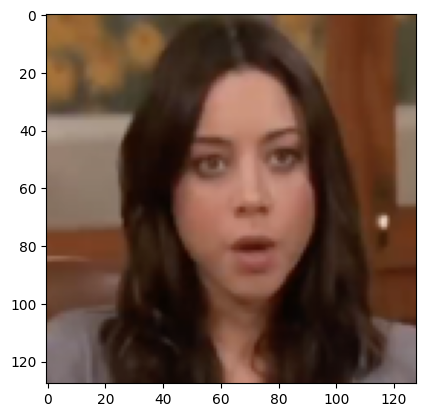

Label: april


In [357]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
imshow(img)
print(f"Label: {classes[label]}")

#### Define basic neural network (same from HW7, after tuning and improvements)

I utilized my model from HW7 and the extra credit portion as well as some improvements like adding dropout and changing the optimizer and loss below! I had increased the number of nodes in the final hidden layer to accomodate the 128x128 images we are working with in this custom dataset.

In [358]:
# basic network
# Network Architecture - Batch Norm
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_fn = nn.ReLU()
        self.kernel_size = 3
        self.padding = 1
        
        # set up 2d convolutions
        self.conv_1 = nn.Conv2d(3, 64, self.kernel_size, 1, self.padding)
        self.norm_1 = nn.BatchNorm2d(64)
        self.pool_1 = nn.MaxPool2d(2, 2)
        
        self.conv_2 = nn.Conv2d(64, 128, self.kernel_size, 1, self.padding)
        self.norm_2 = nn.BatchNorm2d(128)
        self.pool_2 = nn.MaxPool2d(2, 2)
        
        self.conv_3 = nn.Conv2d(128, 128, self.kernel_size, 1, self.padding)
        self.norm_3 = nn.BatchNorm2d(128)
        self.pool_3 = nn.MaxPool2d(2, 2)
        
        self.conv_4 = nn.Conv2d(128, 128, self.kernel_size, 1, self.padding)
        self.norm_4 = nn.BatchNorm2d(128)
        self.pool_4 = nn.MaxPool2d(2, 2)
        
        # set up fully connected layer
        self.num_lin_inputs = 512 * 4 * 4
        self.fc_1 = nn.Linear(self.num_lin_inputs, 5)
        
        # add dropout
        self.dropout = nn.Dropout(0.4)
        
        ### END YOUR CODE

    def forward(self, x):
        ### YOUR CODE HERE
        
        # apply activation func to conv layers
        layer_1 = self.act_fn(self.norm_1(self.conv_1(x)))
        pooled_layer_1 = self.pool_1(layer_1) 
        
        layer_2 = self.act_fn(self.norm_2(self.conv_2(pooled_layer_1)))
        pooled_layer_2 = self.pool_2(layer_2)
        
        layer_3 = self.act_fn(self.norm_3(self.conv_3(pooled_layer_2)))
        pooled_layer_3 = self.pool_3(layer_3)
        
        layer_4 = self.act_fn(self.norm_4(self.conv_4(pooled_layer_3)))
        pooled_layer_4 = self.pool_4(layer_4)
        
        # reshape using view()
        reshaped = pooled_layer_4.view(-1, self.num_lin_inputs)
        
        # input into fully connected layers
        dropped = self.dropout(reshaped)
        x = self.fc_1(dropped)
        
        ### END YOUR CODE
        return x

#### Train the basic model

In [359]:
net = Net()

criterion = nn.CrossEntropyLoss()

# optimizer is AdamW
optimizer = optim.AdamW(net.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [360]:
epoch_num = 25
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if (epoch + 1) % 5 == 0 and (i + 1) % 10 == 0: 
            print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss))
        running_loss = 0.0
        
    scheduler.step()

print('Finished Training')

[5,    10] loss: 0.011
[5,    20] loss: 0.009
[5,    30] loss: 0.861
[5,    40] loss: 2.594
[5,    50] loss: 0.015
[5,    60] loss: 0.001
[10,    10] loss: 0.002
[10,    20] loss: 0.000
[10,    30] loss: 0.002
[10,    40] loss: 0.002
[10,    50] loss: 0.029
[10,    60] loss: 0.000
[15,    10] loss: 0.000
[15,    20] loss: 0.000
[15,    30] loss: 0.002
[15,    40] loss: 0.000
[15,    50] loss: 0.001
[15,    60] loss: 0.002
[20,    10] loss: 0.000
[20,    20] loss: 0.000
[20,    30] loss: 0.000
[20,    40] loss: 0.005
[20,    50] loss: 0.003
[20,    60] loss: 0.001
[25,    10] loss: 0.000
[25,    20] loss: 0.000
[25,    30] loss: 0.001
[25,    40] loss: 0.000
[25,    50] loss: 0.002
[25,    60] loss: 0.000
Finished Training


#### Ensure the model achieves high accuracy on training images

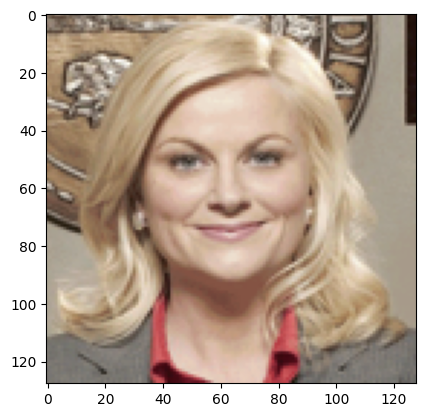

real: leslie
predicted: leslie


In [361]:
train_features, train_labels = next(iter(trainloader))
model_output = net.forward(train_features)
predicted = torch.max(model_output, 1)[1]

img = train_features[0].squeeze()
imshow(img)

# check groundtruth
for p in range(len(predicted)):
    print("real: " + classes[train_labels[p]])
    print("predicted: " +  classes[predicted[p]])

In [362]:
# test all train images
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        # Similar to the previous question, calculate model's output and the percentage as correct / total
        model_output = net.forward(images)
        predicted = torch.max(model_output, 1)[1]
        
        for i, curr_label in enumerate(labels):
            curr = predicted[i]
            if curr == curr_label:
                correct += 1
            total += 1

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 100 %


#### Utilize testing data in checking accuracy of model

In [370]:
# prepare to count predictions for each character
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# test all test images
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Similar to the previous question, calculate model's output and the percentage as correct / total
        model_output = net.forward(images)
        predicted = torch.max(model_output, 1)[1]
        
        for i, curr_label in enumerate(labels):
            curr = predicted[i]
            curr_class = classes[curr_label]
            
            if curr == curr_label:
                correct += 1
                correct_pred[curr_class] += 1
            total += 1
            total_pred[curr_class] += 1

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

print("")

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for character {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy of the network on the test images: 71 %

Accuracy for character leslie is: 100.0 %
Accuracy for character ben   is: 100.0 %
Accuracy for character ron   is: 33.3 %
Accuracy for character donna is: 80.0 %
Accuracy for character april is: 75.0 %


**Performance:** Accuracy fluctuates between 69-80% with an average of 71%

Now that we have finished training our model on some images of the characters we will use in our video portion, we can move on to actually utilizing TV show clips!

In [371]:
# saving model for future use
torch.save(net.state_dict(), PATH)

### Video Processing

Using some of my code from HW5, we can identify the characters in short video clips from the show itself. The code uses the animated bbox from the utils file! In this section, I used [OpenCV](https://www.futurelearn.com/info/courses/introduction-to-image-analysis-for-plant-phenotyping/0/steps/305359) to read in my clipped video files and frames from the show. This first section is just a test video to see how the video processing and model input works!

In [372]:
# import open CV to read video files and get image frames from them
import cv2

# import other imaging libraries
import numpy as np
from skimage import filters
from skimage.feature import corner_peaks
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import HTML
import os
from utils import animated_frames, load_frames
import shutil

# reset gen_frames folder and create a new one
shutil.rmtree('./gen_frames')
newpath = './gen_frames'
if not os.path.exists(newpath):
    os.makedirs(newpath)

# get the video from path
video_path = "./pnr_data/clips/leslie_1.mp4"
pre_path = os.path.splitext(video_path)[0]
splitted = pre_path.split('/')[-1]
class_name = splitted.split('_')[0]
print("Current class name: " + class_name)

Current class name: leslie


In [373]:
# get video objects
video = cv2.VideoCapture(video_path)

# print fps
fps = video.get(cv2.CAP_PROP_FPS)
print('frames per second =',fps)

frames per second = 25.0


In [374]:
# read and save the frames with reduced FPS to make process more efficient
target_div = 2 # cut the amount of frames by 5
success, image = video.read()
frame_count = 0
file_count = 1

# create subfolder
path_for_class = 'gen_frames/'+class_name
if(not os.path.exists(path_for_class)):
    os.mkdir(path_for_class)
    
while success:
    if (frame_count % target_div) == 0:
        cv2.imwrite(f"./gen_frames/{class_name}/frame_{file_count}.jpg", image)
        success, image = video.read()
        file_count += 1
        frame_count += 1
    else: 
        success = video.grab() 
        frame_count += 1
video.release()

Now that we have extracted the frames from the video, we can try and crop the facial features located within the bounding boxes!

Showing video frames:


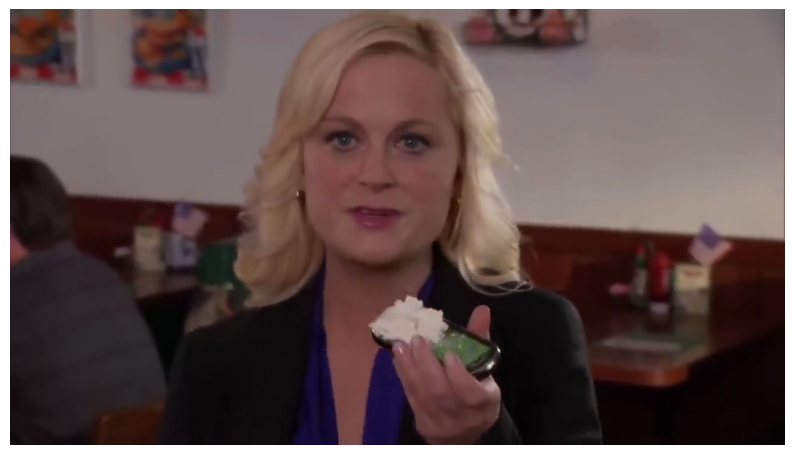

In [375]:
# load video frames
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_UNCHANGED)
        
        # we have to convert the image's color channels to be able to get the right frame colors
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

print("Showing video frames:")
frames = load_images_from_folder('gen_frames/' + class_name)
ani = animated_frames(frames)
HTML(ani.to_html5_video())

Here, we can attempt to apply the concepts from HW 5 but because we don't want to rely on pre-labeled ground truth boxes, we have to utilize more advance tech to figure out the character's face locations to crop the box. Therefore, we use built in [libraries from OpenCV](https://docs.opencv.org/2.4/doc/user_guide/ug_traincascade.html) to achieve this.

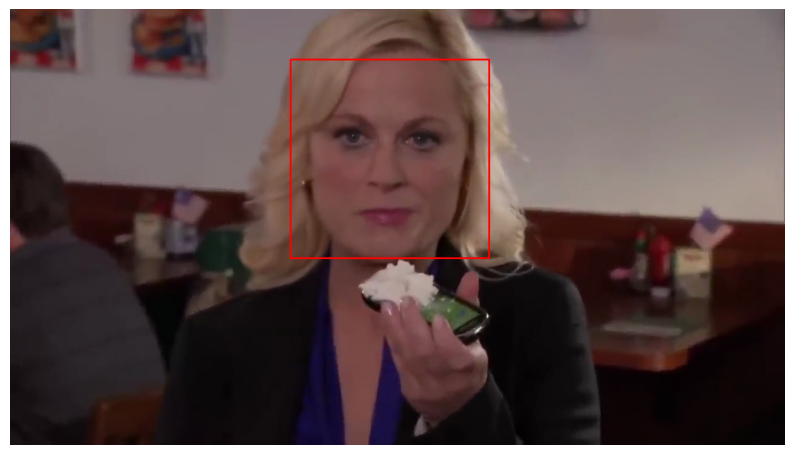

In [376]:
# apply facial recognition and boxes
face_cascade = cv2.CascadeClassifier(os.path.join(cv2.data.haarcascades, 'haarcascade_frontalface_default.xml'))

# get current image
rect_img = cv2.imread(os.path.join('gen_frames/'+class_name, 'frame_1.jpg'), cv2.IMREAD_UNCHANGED)
rect_img = cv2.cvtColor(rect_img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(rect_img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(rect_img, 1.1, 5, 0, (200, 200))
for (x,y,w,h) in faces:
    rect_img = cv2.rectangle(rect_img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]

figsize=(10,8)
fig, ax = plt.subplots(figsize=figsize)
ax.axis('off')
im = ax.imshow(rect_img)

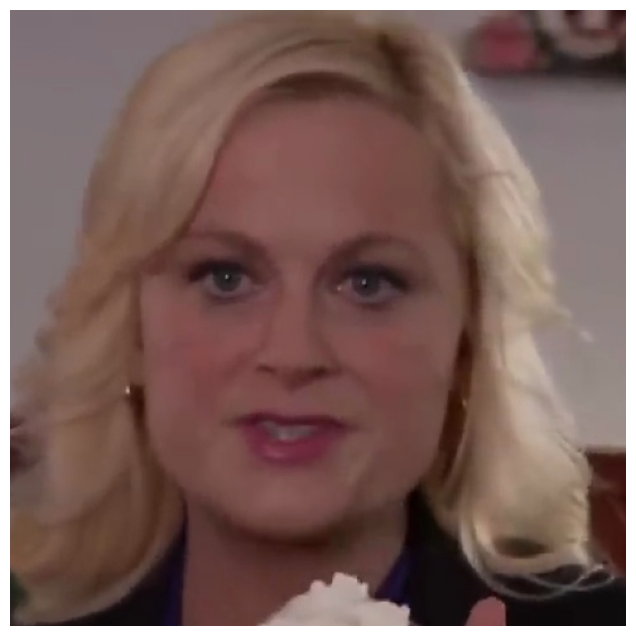

In [384]:
# crop photo with pixel padding to get the whole face
px,py = 80, 80

img = frames[0]
cropped = img[y-py:y+h+py, x-px:x+w+px]
figsize=(10,8)
fig, ax = plt.subplots(figsize=figsize)
ax.axis('off')
im = ax.imshow(cropped)

In [378]:
# apply crop to all images in the test clip and rewrite old ones
file_count = 1
for image in frames:
    cropped = image[y-py:y+h+py, x-px:x+w+px]
    cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"./gen_frames/{class_name}/frame_{file_count}.jpg", cropped)
    file_count+=1

In [379]:
# load in model checkpoint
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

torch.Size([1, 3, 128, 128])


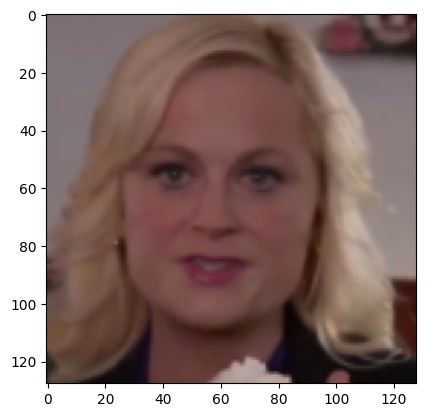

predicted: leslie


In [380]:
# check performance of data
norm_transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_frame_data = torchvision.datasets.ImageFolder('gen_frames', transform=norm_transform)
testloader = torch.utils.data.DataLoader(test_frame_data, batch_size = 1, shuffle = True)

test_features, test_labels = next(iter(testloader))

# show image size to make sure corrct tensor dimensions
print(test_features.shape)

# apply model to frames
model_output = net.forward(test_features)
predicted = torch.max(model_output, 1)[1]

# show one of the image frames
img = test_features[0].squeeze()
imshow(img)

for p in range(len(predicted)):
    print("predicted: " +  classes[predicted[p]])

Now, that we have tested our video data on a sample video and it outputted the correct character, let's put it into action with all of the other test clips!

In [349]:
# input a clip file here to test it :)

'''
list of test clip paths to copy/paste:

"./pnr_data/clips/april_1.mp4"
"./pnr_data/clips/april_2.mp4"
"./pnr_data/clips/ben_1.mp4"
"./pnr_data/clips/ben_2.mp4"
"./pnr_data/clips/donna_1.mov"
"./pnr_data/clips/donna_2.mov"
"./pnr_data/clips/leslie_2.mp4"
"./pnr_data/clips/leslie_2.mp4"
"./pnr_data/clips/ron_1.mov"
"./pnr_data/clips/ron_2.mov"

'''
video_path = "./pnr_data/clips/episode/1.mov"

Showing video frames:


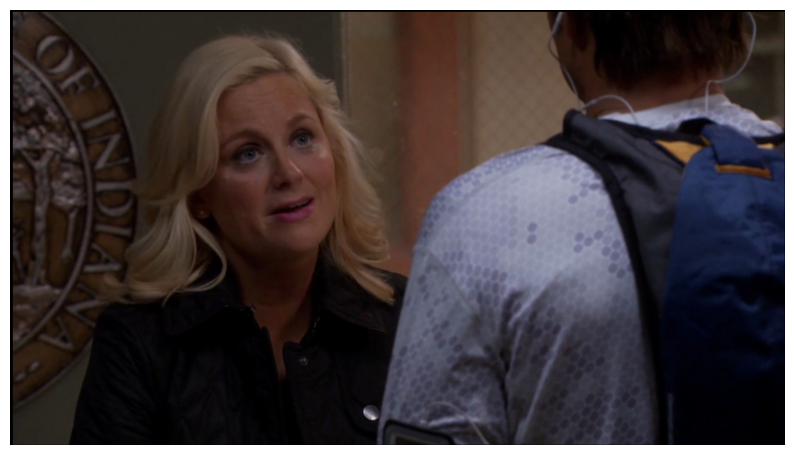

In [350]:
# put all of the code into a place

# load in model checkpoint
net = Net()
net.load_state_dict(torch.load(PATH))

# reset gen_frames folder and create a new one
shutil.rmtree('./gen_frames')
newpath = './gen_frames'
if not os.path.exists(newpath):
    os.makedirs(newpath)

# get the video from path
pre_path = os.path.splitext(video_path)[0]
splitted = pre_path.split('/')[-1]
class_name = splitted.split('_')[0]

# get video objects
video = cv2.VideoCapture(video_path)

# read and save the frames with reduced FPS to make process more efficient
target_div = 2 # cut the amount of frames by 5
success, image = video.read()
frame_count = 0
file_count = 1

# create subfolder
path_for_class = 'gen_frames/'+class_name
if(not os.path.exists(path_for_class)):
    os.mkdir(path_for_class)
    
while success:
    if (frame_count % target_div) == 0:
        cv2.imwrite(f"./gen_frames/{class_name}/frame_{file_count}.jpg", image)
        success, image = video.read()
        file_count += 1
        frame_count += 1
    else: 
        success = video.grab() 
        frame_count += 1
video.release()

# load video frames
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_UNCHANGED)
        
        # we have to convert the image's color channels to be able to get the right frame colors
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

print("Showing video frames:")
frames = load_images_from_folder('gen_frames/' + class_name)
ani = animated_frames(frames)
HTML(ani.to_html5_video())

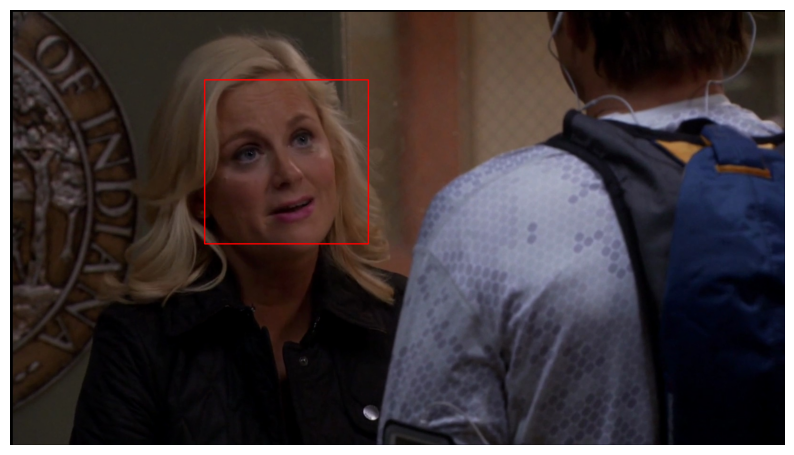

In [351]:
# begin face recognition

# apply facial recognition and boxes
face_cascade = cv2.CascadeClassifier(os.path.join(cv2.data.haarcascades, 'haarcascade_frontalface_default.xml'))

# get current image
rect_img = cv2.imread(os.path.join('gen_frames/'+class_name, 'frame_1.jpg'), cv2.IMREAD_UNCHANGED)
rect_img = cv2.cvtColor(rect_img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(rect_img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(rect_img, 1.1, 5, 0, (200, 200))
for (x,y,w,h) in faces:
    rect_img = cv2.rectangle(rect_img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]

figsize=(10,8)
fig, ax = plt.subplots(figsize=figsize)
ax.axis('off')
im = ax.imshow(rect_img)

px,py = 80, 80

# apply crop to all images in the test clip and rewrite old ones
file_count = 1
for image in frames:
    cropped = image[y-py:y+h+py, x-px:x+w+px]
    cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"./gen_frames/{class_name}/frame_{file_count}.jpg", cropped)
    file_count+=1

torch.Size([1, 3, 128, 128])


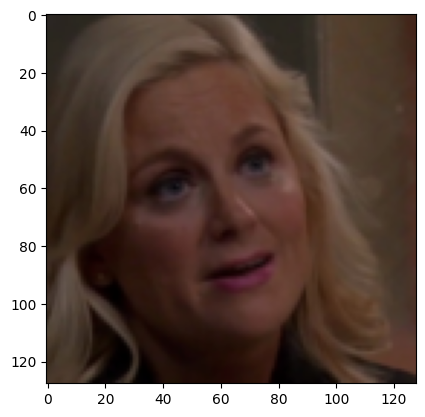

predicted: leslie


In [352]:
# check performance of data
norm_transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_data = torchvision.datasets.ImageFolder('gen_frames', transform=norm_transform)
testloader_vid = torch.utils.data.DataLoader(test_data, batch_size = 1, shuffle = True)

# show image size to make sure corrct tensor dimensions
test_features, test_labels = next(iter(testloader_vid))
print(test_features.shape)

# apply model to frames
model_output = net.forward(test_features)
predicted = torch.max(model_output, 1)[1]

# show one of the image frames
img = test_features[0].squeeze()
imshow(img)

for p in range(len(predicted)):
    print("predicted: " +  classes[predicted[p]])

#### Putting the model to the actual test
In the table below, I manually ran some clips from an actual episode of Parks and Recreation, the Christmas one in season 4 called "Citizen Knope". I had to manually download them and pick out clips that would be viable for my model. To see the clips, navigate to the [episodes folder within clips](./pnr_data/clips/episode). The results are below:

| File Name | Actual Character                   | Predicted | Correct? |
|-----------|-----------------------------|-----------|----------|
| 1.mov     | leslie                      | leslie    | yes        |
| 2.mov     | donna                       | donna     | yes        |
| 3.mov     | april                       | april     | yes        |
| 4.mov     | ron                         | april     | no        |
| 5.mov     | leslie                      | april     | no        |
| 6.mov     | ben                         | ron       | no        |
| 7.mov     | april                       | april     | yes        |
| 8.mov     | ron                         | ron       | yes        |
| 9.mov     | leslie                      | leslie    | yes        |
| 10.mov    | ben                         | ben       | yes        |
| 11.mov    | leslie                      | april     | no        |
| 12.mov    | april  | april     | yes        |
| 13.mov    | ben                         | ben       | yes        |
| 14.mov    | donna                       | donna     | yes        |

**Discussion of results:**

From the table above, we see that 10 out of the 14 clips were classified correctly which is about 71.4% accurate. Interestingly enough, this is the common accuracy value that my original model had on test data which is great. Some other things I noticed included gender related confusion from my model. More often than not, if my model tried to incorrectly classify a picture of Ron, it would be labeled as Ben. On the flip side, if I gave my model a picture of April, sometimes it would result in Leslie being the prediction. 

This is an important thing to note because the features like hair, skin tone, environment and clothing somehow played a factor within my pretty simple neural network. The features that were in common with mixed up predictions were understandable and in the future, fine tuning this more with more dataset images could be a way to improve. Additionally, being able to generalize this model to the entire cast and with multiple people in a scene would be awesome!